In [1]:
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

np.set_printoptions(suppress=True)

In [2]:
cadralazine_data = pd.DataFrame(collections.OrderedDict([
    ('time', [2, 4, 6, 8, 10, 24, 28, 32]),
    ('drug concentration', [1.63, 1.01, 0.73, 0.55, 0.41, 0.01, 0.06, 0.02])
]), index=pd.Series(np.arange(1, 9), name='$i$'))
with open('p3_data.tex', 'w') as f:
    f.write(cadralazine_data.reset_index().to_latex(escape=False, index=False))
cadralazine_data

,time,drug concentration
$i$,,
1,2,1.63
2,4,1.01
3,6,0.73
4,8,0.55
5,10,0.41
6,24,0.01
7,28,0.06
8,32,0.02


In [3]:
D = 30 # Specified in homework

def compute_mle_estimates(x, y):
    assert len(x) == len(y), 'Inputs must have the same length.'
    n = len(x)
    log_D = np.log(D)
    log_y = np.log(y)
    x_sum = np.sum(x)
    log_y_sum = np.sum(log_y)    
    
    k_e = -(n*np.sum(x*log_y) - x_sum*log_y_sum)/(n*np.sum(x*x) - x_sum*x_sum)
    log_V = -(log_y_sum + k_e*x_sum)/n + log_D
    sigma_2 = np.mean(np.square(log_y - log_D + log_V + k_e*x))
    return np.exp(log_V), k_e, sigma_2    
estimates = compute_mle_estimates(cadralazine_data['time'], cadralazine_data['drug concentration'])

In [4]:
def compute_asymptotic_covariances(x, V, k_e, sigma_2):
    n, var_x = len(x), np.var(x, ddof=0)    
    covariances = np.zeros((3,3))
    covariances[0, 0] = np.mean(np.square(x))*sigma_2*V*V/n/var_x
    covariances[1, 1] = sigma_2/var_x/n
    covariances[2, 2] = 2*sigma_2*sigma_2/n
    covariances[0, 1] =  covariances[1, 0] = -sigma_2*V*np.mean(x)/n/var_x
    return covariances

asymptotic_covariances = compute_asymptotic_covariances(
    cadralazine_data['time'], *estimates)

In [5]:
estimates_summary = pd.DataFrame(collections.OrderedDict([
    ('Estimate', estimates),
    ('Standard error', np.sqrt(np.diag(asymptotic_covariances))),
    ('95\% CI lower bound', estimates + np.sqrt(np.diag(asymptotic_covariances))*stats.norm.ppf((1 - 0.95)/2)),
    ('95\% CI upper bound', estimates + np.sqrt(np.diag(asymptotic_covariances))*stats.norm.isf((1 - 0.95)/2)),
]), index=['$\hat{V}$', '$\hat{k}_e$', '$\hat{\sigma}^2$'])

with open('p3_summary.tex', 'w') as f:
    f.write(estimates_summary.to_latex(escape=False))

estimates_summary

,Estimate,Standard error,95\% CI lower bound,95\% CI upper bound
$\hat{V}$,16.663309,6.165432,4.579285,28.747333
$\hat{k}_e$,0.152106,0.020508,0.111911,0.192302
$\hat{\sigma}^2$,0.411963,0.205981,0.008247,0.815679


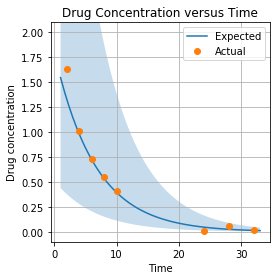

In [6]:
def plot_fitted_curve(ax, data, estimates, confidence_level=0.95):    
    V, k_e, sigma_2 = estimates
    x = np.linspace(data['time'].min() - 1, data['time'].max() + 1)
    y = D/V*np.exp(-k_e*x)
    y_upper = y*np.exp(np.sqrt(sigma_2)*stats.norm.isf((1 - confidence_level)/2))
    y_lower = y*np.exp(np.sqrt(sigma_2)*stats.norm.ppf((1 - confidence_level)/2))

    ax.fill_between(x, y_lower, y_upper, alpha=1/4)    
    ax.plot(x, y, '-', label='Expected')    
    ax.plot(data['time'], data['drug concentration'], 'o', label='Actual')
    ax.set_xlabel('Time')
    ax.set_ylabel('Drug concentration')
    ax.grid(True)
    ax.legend()

fig = plt.figure(figsize=(4,4))
ax = fig.gca()
#plot_fitted_curve(ax, cadralazine_data, estimates, stats.norm.cdf(1) - stats.norm.cdf(-1))
plot_fitted_curve(ax, cadralazine_data, estimates)
ax.set_title('Drug Concentration versus Time')
ax.set_ylim(bottom=-0.1, top=2.1)
fig.tight_layout()
fig.savefig('p3_fitted_curve.pdf', bbox_inches='tight')

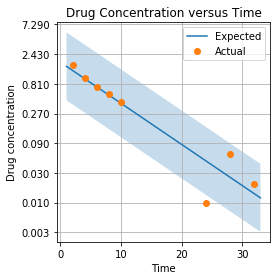

In [7]:
fig = plt.figure(figsize=(4,4))
ax = fig.gca()
plot_fitted_curve(ax, cadralazine_data, estimates)
ax.set_yscale('log', basey=np.exp(1))
ax.set_yticks([0.01/3, 0.01, 0.03, 0.09, 0.27, 0.81, 2.43, 7.29])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_title('Drug Concentration versus Time')
fig.tight_layout()
fig.savefig('p3_fitted_curve_log.pdf', bbox_inches='tight')

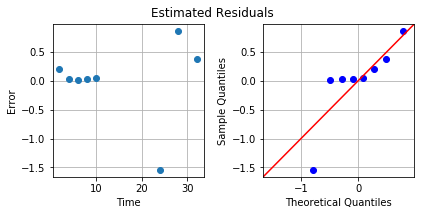

In [8]:
fig, axes = plt.subplots(figsize=(6, 3), ncols=2)

def plot_residuals(axes, data, estimates):
    ax_residuals, ax_qq = axes
    V, k_e, sigma_2 = estimates
    log_y_hat = np.log(D) - np.log(V) - k_e*data['time']
    log_y = np.log(data['drug concentration'])
    residuals = log_y - log_y_hat
    
    ax_residuals.plot(data['time'], residuals, 'o')
    ax_residuals.set_xlabel('Time')
    ax_residuals.set_ylabel('Error')
    ax_residuals.grid(True)
    
    sm.qqplot(residuals, ax=ax_qq, line='45', loc=0, scale=np.sqrt(sigma_2), fit=False)    
    ax_qq.grid(True)
        
    return residuals

plot_residuals(axes, cadralazine_data, estimates)
fig.suptitle('Estimated Residuals')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig('p3_residuals.pdf', bbox_inches='tight')

In [9]:
def compute_parameters_of_interest(x, V, k_e, sigma_2):
    n = len(x)
    var_x = np.var(x, ddof=0)
    clearance_variance = np.squeeze(sigma_2*np.array([k_e, V]).dot(
        np.array([[V*V/n*np.sum(np.square(x)), -V*np.mean(x)], [-V*np.mean(x), 1]]).dot(
            [[k_e], [V]]))/n/var_x)
    elimination_variance = sigma_2/n/var_x*np.square(np.log(2)/k_e**2)

    estimates = np.array([V*k_e, np.log(2)/k_e])
    standard_errors = np.sqrt([clearance_variance, elimination_variance])

    return pd.DataFrame(collections.OrderedDict([
        ('Estimate', estimates),
        ('Standard error', standard_errors),
        ('95\% CI lower bound', estimates + standard_errors*stats.norm.ppf((1-0.95)/2)),
        ('95\% CI upper bound', estimates + standard_errors*stats.norm.isf((1-0.95)/2))
    ]), index=['Clearance ($Cl$)', 'Elimination half-life ($x_{1/2}$)'])

parameters_of_interest = compute_parameters_of_interest(cadralazine_data['time'], *estimates)
with open('p3_parameters_of_interest.tex', 'w') as f:
    f.write(parameters_of_interest.to_latex(escape=False))
parameters_of_interest

,Estimate,Standard error,95\% CI lower bound,95\% CI upper bound
Clearance ($Cl$),2.534595,0.700000,1.162621,3.90657
Elimination half-life ($x_{1/2}$),4.556990,0.614409,3.352771,5.76121
